code to predict pv generation

In [106]:
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.ticker import MaxNLocator # To ensure demand axis are integer.


from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb



# Third party packages.
import os                       # Execute tasks related to your operating system.

import polars as pl             # Data handling ('Blazingly fast DataFrames') and is a drop-in replacement for pandas.
import pickle                   # Save and load data to and from pickle files.
import time
import json
import os
import joblib

from icecream import ic         # Print variables.
from datetime import datetime

import time


Data Understanding

Load data set. Split with 80% and 20% split

In [107]:
# Load API Key and download directory from config file
CONFIG_FILE = "../config/api-call.json"

def load_config(config_path):
    """Load configuration from a JSON file."""
    with open(config_path, "r") as file:
        return json.load(file)

# Load config values
config = load_config(CONFIG_FILE)

# print(config)
DOWNLOAD_DIR = config["ned"]["ned_download_dir"]
CSV_DOWNLOAD_DIR = config["ned"]["ned_test_download_dir"]
MODEL_RUN_RESULTS_DIR = config["ned"]["ned_model_run_download_dir"]

print("DOWNLOAD_DIR :", DOWNLOAD_DIR)
# pkl_file_path = f'{DOWNLOAD_DIR}/power-gen-type-0.pkl'
csv_file_path = f'{DOWNLOAD_DIR}power-gen-consolidated-data-2022-2024.csv'

# with open('../data/dc-ned-json-data-1.pkl', 'rb') as pickle_file:
# with open(pkl_file_path, 'rb') as pickle_file:
with open(csv_file_path, 'rb') as csv_file:
    df_pd_orig = pd.read_csv(csv_file)

# Sum of all columns starting with 'production'
# df_pd_orig["Total_Production"] = df_pd_orig.filter(like="production").sum(axis=1)
df_pd_orig["Total_Production"] = df_pd_orig["volume_0"]
df_pd_orig.rename(columns={'date_x': 'validto'}, inplace=True)

# Show a sample of first 3 rows.
df_pd_orig.head(3)


DOWNLOAD_DIR : ../data/powergen/


,validto,capacity_0,volume_0,capacity_1,production_wind,capacity_2,production_solar,capacity_4,production_heatpump,capacity_8,...,production_electricitymix,capacity_28,volume_28,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
0,2022-01-01 00:00:00+00:00,8098513,8098513,2031015,2031015,0,0,161795,161795,699000,...,10246506,NaN,NaN,1127491,1127491,482,482,1865500,1865500,8098513
1,2022-01-01 01:00:00+00:00,7914843,7914843,1864849,1864849,0,0,198870,198870,699000,...,10083044,NaN,NaN,1184195,1184195,391,391,1839500,1839500,7914843
2,2022-01-01 02:00:00+00:00,7442013,7442013,1784513,1784513,0,0,222172,222172,698995,...,9595627,NaN,NaN,1181864,1181864,444,444,1429250,1429250,7442013


Descriptive Statistics

In [108]:
# Using Pandas.
df_pd_num = df_pd_orig.select_dtypes(include='number')

# Column names (Pandas: df_pd_orig_num.columns.tolist()).
l_df_num_names = df_pd_num.columns
print(f"We have {len(l_df_num_names)} numerical variables:\n{l_df_num_names}")

# Convert to datetime format
df_pd_orig_str = df_pd_orig.select_dtypes(include='object')
print("Number of rows:", df_pd_orig_str.shape[0], "and column names are:", df_pd_orig_str.columns, "and column types are:", df_pd_orig_str.dtypes)

We have 49 numerical variables:
Index(['capacity_0', 'volume_0', 'capacity_1', 'production_wind', 'capacity_2',
       'production_solar', 'capacity_4', 'production_heatpump', 'capacity_8',
       'production_cofiring', 'capacity_9', 'production_geothermal',
       'capacity_10', 'production_other', 'capacity_11', 'production_waste',
       'capacity_12', 'production_biooil', 'capacity_13', 'production_biomass',
       'capacity_14', 'production_wood', 'capacity_17',
       'production_windoffshore', 'capacity_18', 'production_fossilgaspower',
       'capacity_19', 'production_fossilhardcoal', 'capacity_20',
       'production_nuclear', 'capacity_21', 'production_wastepower',
       'capacity_22', 'production_windoffshoreB', 'capacity_25',
       'production_biomasspower', 'capacity_26', 'production_otherpower',
       'capacity_27', 'production_electricitymix', 'capacity_28', 'volume_28',
       'capacity_35', 'production_CHP_total', 'capacity_50',
       'production_solarthermal', 'c

To check if the output column has unique values

In [109]:
l_col = ['Total_Production']

for s_col in l_col:
    print(f"{l_col}: {df_pd_orig[l_col]}")
    print(f"{s_col}: {df_pd_orig[s_col].unique()}")

['Total_Production']:        Total_Production
0               8098513
1               7914843
2               7442013
3               7470598
4               7425668
...                 ...
26299          15441356
26300          15390012
26301          15298923
26302          15150733
26303          15169196

[26304 rows x 1 columns]
Total_Production: [ 8098513  7914843  7442013 ... 15298923 15150733 15169196]


Contruct a descriptive summary

In [110]:
df_pd_orig.describe()

,capacity_0,volume_0,capacity_1,production_wind,capacity_2,production_solar,capacity_4,production_heatpump,capacity_8,production_cofiring,...,production_electricitymix,capacity_28,volume_28,capacity_35,production_CHP_total,capacity_50,production_solarthermal,capacity_51,production_allconsuminggas,Total_Production
count,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,2.630400e+04,26304.000000,26304.000000,...,2.630400e+04,6.377000e+03,6.377000e+03,2.630400e+04,2.630400e+04,26304.000000,26304.000000,2.630400e+04,2.630400e+04,2.630400e+04
mean,1.002881e+07,1.002881e+07,1.867822e+06,1.867822e+06,2.467901e+06,2.467901e+06,6.375008e+05,6.375008e+05,680711.491940,680711.491940,...,1.352914e+07,1.131498e+07,1.131498e+07,1.663086e+06,1.663086e+06,42418.259960,42418.259960,1.308883e+06,1.308883e+06,1.002881e+07
std,4.730942e+06,4.730942e+06,1.724212e+06,1.724212e+06,3.850288e+06,3.850288e+06,4.450993e+05,4.450993e+05,27603.187466,27603.187466,...,4.009711e+06,1.358170e+06,1.358170e+06,6.544200e+05,6.544200e+05,65692.270586,65692.270586,1.068610e+06,1.068610e+06,4.730942e+06
min,2.495282e+06,2.495282e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.925200e+04,3.925200e+04,600089.000000,600089.000000,...,3.476983e+06,3.885110e+06,3.885110e+06,4.414480e+05,4.414480e+05,0.000000,0.000000,0.000000e+00,0.000000e+00,2.495282e+06
25%,6.201201e+06,6.201201e+06,3.823895e+05,3.823895e+05,0.000000e+00,0.000000e+00,2.965032e+05,2.965032e+05,674888.000000,674888.000000,...,1.049245e+07,1.096225e+07,1.096225e+07,1.177204e+06,1.177204e+06,355.000000,355.000000,3.720008e+05,3.720008e+05,6.201201e+06
50%,9.336639e+06,9.336639e+06,1.311126e+06,1.311126e+06,8.141500e+04,8.141500e+04,5.699665e+05,5.699665e+05,693450.000000,693450.000000,...,1.326964e+07,1.139893e+07,1.139893e+07,1.566794e+06,1.566794e+06,1933.000000,1933.000000,1.060625e+06,1.060625e+06,9.336639e+06
75%,1.302629e+07,1.302629e+07,3.046544e+06,3.046544e+06,3.826383e+06,3.826383e+06,8.631202e+05,8.631202e+05,699456.000000,699456.000000,...,1.640090e+07,1.220615e+07,1.220615e+07,2.025625e+06,2.025625e+06,63783.750000,63783.750000,2.090000e+06,2.090000e+06,1.302629e+07
max,2.918097e+07,2.918097e+07,6.518273e+06,6.518273e+06,1.973623e+07,1.973623e+07,3.208576e+06,3.208576e+06,699995.000000,699995.000000,...,2.967770e+07,1.488739e+07,1.488739e+07,3.940000e+06,3.940000e+06,296529.000000,296529.000000,4.342999e+06,4.342999e+06,2.918097e+07


Function to capture metrics from prediction models

In [111]:
# Custom function for MAPE and sMAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mape(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

# Function to compute AIC for regression models
def compute_aic(y_true, y_pred, num_params):
    residuals = y_true - y_pred
    mse = np.mean(residuals**2)
    n = len(y_true)
    aic = n * np.log(mse) + 2 * num_params  # AIC formula
    return aic

# List to store results
results = []

Prepare data for prediction

In [112]:
# Step 1: Convert 'validto' column to datetime
df_pd_orig['validto'] = pd.to_datetime(df_pd_orig['validto'])

# Step 2: Sort the DataFrame by 'validto' to avoid data leakage
df = df_pd_orig.sort_values(by='validto')

df['year'] = df['validto'].dt.year
df['month'] = df['validto'].dt.month
df['day'] = df['validto'].dt.day
df['day_of_week'] = df['validto'].dt.dayofweek
df['week_of_year'] = df['validto'].dt.isocalendar().week

df['lag_1'] = df['Total_Production'].shift(1)
df['lag_2'] = df['Total_Production'].shift(2)
df['rolling_mean_3'] = df['Total_Production'].shift(1).rolling(window=3).mean()

features = ['year', 'month', 'day', 'day_of_week', 'week_of_year', 'lag_1', 'lag_2', 'rolling_mean_3']
X = df[features]
y = df['Total_Production']

tscv = TimeSeriesSplit(n_splits=5)

# Example to get the latest train-test split
for train_index, test_index in tscv.split(df):
    train = df.iloc[train_index].copy()
    test = df.iloc[test_index].copy()


Use of TImeseries split to avoid data leakage. Then perform prediction using regression models

Mean Absolute Error (MAE): 4693590.627575556
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1719907200]  ┆ 9965954  ┆ 11044779  ┆ -1078825 │
│ [1719910800]  ┆ 11401283 ┆ 11044876  ┆ 356407   │
│ [1719914400]  ┆ 13011227 ┆ 11044974  ┆ 1966253  │
│ [1719918000]  ┆ 14483817 ┆ 11045071  ┆ 3438746  │
│ [1719921600]  ┆ 15102601 ┆ 11045169  ┆ 4057432  │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735671600]  ┆ 15441356 ┆ 11471580  ┆ 3969776  │
│ [1735675200]  ┆ 15390012 ┆ 11471678  ┆ 3918334  │
│ [1735678800]  ┆ 15298923 ┆ 11471775  ┆ 3827148  │
│ [1735682400]  ┆ 15150733 ┆ 11471873  ┆ 3678860  │
│ [1735686000]  ┆ 15169196 ┆ 11471970  ┆ 3697226  │
└───────────────┴──────────┴───────────┴──────────┘


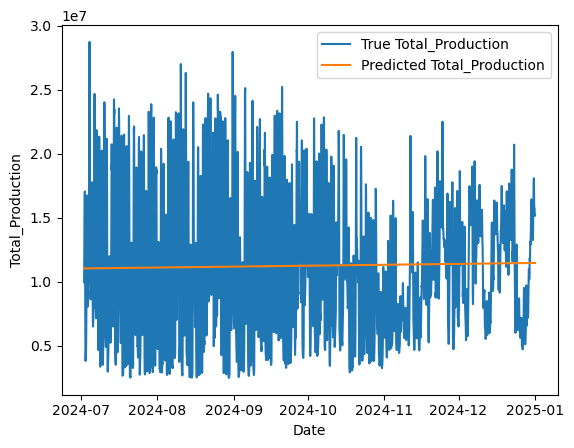

In [113]:
# Step 4: Convert 'validto' (datetime) to numeric format (Unix timestamp in seconds)
train['validto_numeric'] = train['validto'].astype('int64') // 10**9  # Convert datetime to numeric timestamp
test['validto_numeric'] = test['validto'].astype('int64') // 10**9

# Step 5: Train the Linear Regression model on 'validto_numeric' column only
X_train = train[['validto_numeric']]  # Use 'validto_numeric' as the input
y_train = train['Total_Production']  # 'Total_Production' as the target

model_run_start_time = time.time()

model = LinearRegression()
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
X_test = test[['validto_numeric']]
y_test = test['Total_Production']

predictions = model.predict(X_test)
y_int_pred = np.round(predictions).astype(int)  # Rounds and converts to int

model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time


# Step 7: Calculate and print performance metrics (e.g., MAE)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Step 8: Visualize the results (optional)
plt.plot(test['validto'], y_test, label='True Total_Production')
plt.plot(test['validto'], predictions, label='Predicted Total_Production')
plt.xlabel('Date')
plt.ylabel('Total_Production')
plt.legend()
plt.show()

aic_lr = compute_aic(y_test, y_int_pred, num_params=X_train.shape[1] + 1)

# Store results
results.append(["Linear Regression", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr,
                execution_time])




Naive Model

In [114]:
# Step 7: Naive Forecast - last value of training set as prediction
model_run_start_time = time.time()
y_naive_pred = np.full_like(y_test, y_train.iloc[-1])
model_run_end_time = time.time()

aic_naive = compute_aic(y_test, y_int_pred, num_params=X_train.shape[1] + 1)

# Step 7: Calculate and print performance metrics (e.g., MAE)
mae_naive = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error (MAE): {mae_naive}")

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time


# Store results
results.append(["Naive Model", 
                mean_absolute_error(y_test, y_naive_pred),
                np.sqrt(mean_squared_error(y_test, y_naive_pred)), 
                mean_absolute_percentage_error(y_test, y_naive_pred), 
                symmetric_mape(y_test, y_naive_pred), 
                aic_naive,
                execution_time])


Mean Absolute Error (MAE): 4693590.627575556


ARIMA Model

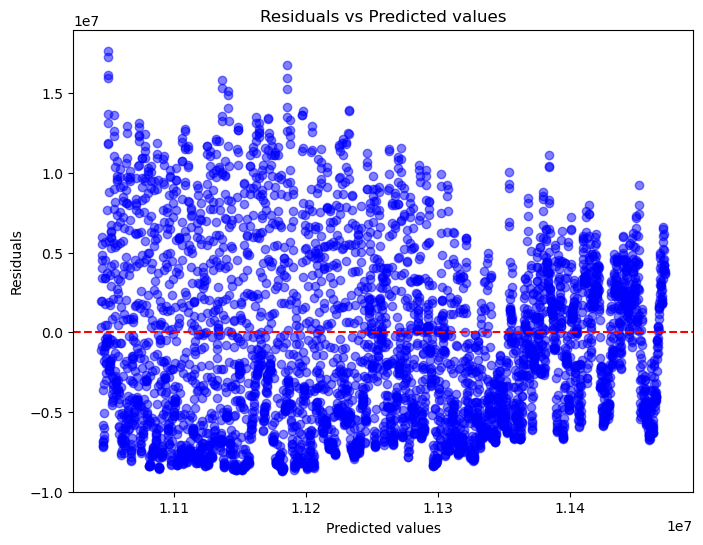

In [115]:
# 2️⃣ ARIMA Model (Example Order: (1,1,1))
model_run_start_time = time.time()
arima_model = ARIMA(y_train, order=(1,1,1)).fit()
y_pred_arima = arima_model.forecast(steps=len(y_test))
model_run_end_time = time.time()

aic_arima = arima_model.aic  # Directly from ARIMA model

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["ARIMA (1,1,1)", 
                mean_absolute_error(y_test, y_pred_arima),
                np.sqrt(mean_squared_error(y_test, y_pred_arima)), 
                mean_absolute_percentage_error(y_test, y_pred_arima), 
                symmetric_mape(y_test, y_pred_arima), 
                aic_arima,
                execution_time])

# 1. Calculate residuals
residuals = y_test - y_int_pred

# 2. Plotting the residuals

# a. Residuals vs. Predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_int_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

SARIMA Model

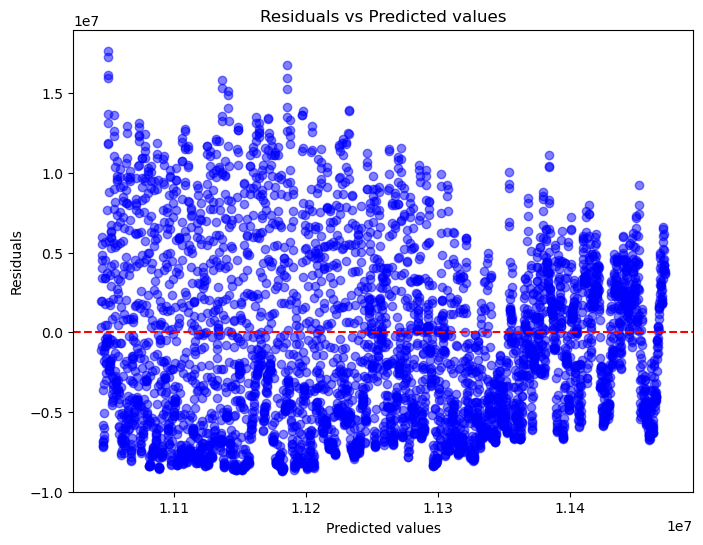

In [116]:
model_run_start_time = time.time()
sarima_model = SARIMAX(y_train, order=(1, 1, 3), seasonal_order=(0, 0, 0, 7)).fit()
# Forecast the next steps (same length as y_test)
y_pred_sarima = sarima_model.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
# Get the AIC value from the SARIMA model
aic_sarima = sarima_model.aic  # Directly from SARIMA model
model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["SARIMAX (1,1,3)", 
                mean_absolute_error(y_test, y_pred_sarima),
                np.sqrt(mean_squared_error(y_test, y_pred_sarima)), 
                mean_absolute_percentage_error(y_test, y_pred_sarima), 
                symmetric_mape(y_test, y_pred_sarima), 
                aic_sarima,
                execution_time])

# 1. Calculate residuals
residuals = y_test - y_int_pred

# 2. Plotting the residuals

# a. Residuals vs. Predicted values plot
plt.figure(figsize=(8, 6))
plt.scatter(y_int_pred, residuals, color='blue', alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Predicted values')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.show()

Predict using LASSO model

In [117]:

# Train Lasso Regression Model
model_run_start_time = time.time()
lasso = Lasso(alpha=0.2)  # Adjust alpha for regularization strength
lasso.fit(X_train, y_train)
# Make Predictions
y_pred = lasso.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int
model_run_end_time = time.time()

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["LASSO", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr,
                execution_time])


Mean Absolute Error: 4693590.627575552
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬──────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff     │
│ ---           ┆ ---      ┆ ---       ┆ ---      │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64      │
╞═══════════════╪══════════╪═══════════╪══════════╡
│ [1719907200]  ┆ 9965954  ┆ 11044779  ┆ -1078825 │
│ [1719910800]  ┆ 11401283 ┆ 11044876  ┆ 356407   │
│ [1719914400]  ┆ 13011227 ┆ 11044974  ┆ 1966253  │
│ [1719918000]  ┆ 14483817 ┆ 11045071  ┆ 3438746  │
│ [1719921600]  ┆ 15102601 ┆ 11045169  ┆ 4057432  │
│ …             ┆ …        ┆ …         ┆ …        │
│ [1735671600]  ┆ 15441356 ┆ 11471580  ┆ 3969776  │
│ [1735675200]  ┆ 15390012 ┆ 11471678  ┆ 3918334  │
│ [1735678800]  ┆ 15298923 ┆ 11471775  ┆ 3827148  │
│ [1735682400]  ┆ 15150733 ┆ 11471873  ┆ 3678860  │
│ [1735686000]  ┆ 15169196 ┆ 11471970  ┆ 3697226  │
└───────────────┴──────────┴───────────┴──────────┘


/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.667e+13, tolerance: 4.592e+13
  model = cd_fast.enet_coordinate_descent(


Predict using decision tree regression

In [118]:

# Train Decision Tree Regressor Model
model_run_start_time = time.time()
dt_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_regressor.fit(X_train, y_train)

# Make Predictions
y_pred = dt_regressor.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int
model_run_end_time = time.time()

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Step 7: Convert Predictions Back to Polars (Optional)
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)

# Store results
results.append(["Decision Tree", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr,
                execution_time])



Mean Absolute Error: 4578736.861216111
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬─────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff    │
│ ---           ┆ ---      ┆ ---       ┆ ---     │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64     │
╞═══════════════╪══════════╪═══════════╪═════════╡
│ [1719907200]  ┆ 9965954  ┆ 10574641  ┆ -608687 │
│ [1719910800]  ┆ 11401283 ┆ 10574641  ┆ 826642  │
│ [1719914400]  ┆ 13011227 ┆ 10574641  ┆ 2436586 │
│ [1719918000]  ┆ 14483817 ┆ 10574641  ┆ 3909176 │
│ [1719921600]  ┆ 15102601 ┆ 10574641  ┆ 4527960 │
│ …             ┆ …        ┆ …         ┆ …       │
│ [1735671600]  ┆ 15441356 ┆ 10574641  ┆ 4866715 │
│ [1735675200]  ┆ 15390012 ┆ 10574641  ┆ 4815371 │
│ [1735678800]  ┆ 15298923 ┆ 10574641  ┆ 4724282 │
│ [1735682400]  ┆ 15150733 ┆ 10574641  ┆ 4576092 │
│ [1735686000]  ┆ 15169196 ┆ 10574641  ┆ 4594555 │
└───────────────┴──────────┴───────────┴─────────┘


Predit using Random Forest regressor

In [119]:
from sklearn.model_selection import GridSearchCV

# Train Random Forest Regressor Model
model_run_start_time = time.time()

# Make Predictions
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5, 10]
}

grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
y_int_pred = np.round(y_pred).astype(int)  # Rounds and converts to int
model_run_end_time = time.time()

# Evaluate Model
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Print Predictions
df_pred = pl.DataFrame({"X Values": X_test.values, "Actual": y_test.values, "Predicted": y_int_pred, "Diff": y_test.values - y_int_pred})
print(df_pred)
'''
MODEL_DOWNLOAD_DIR = config["ned"]["ned_model_download_dir"]
model_pkl_file_path = f'{MODEL_DOWNLOAD_DIR}power-gen-random-forest-model-0.pkl'
print("model_pkl_file_path :", model_pkl_file_path)

# Save the trained model
joblib.dump(rf_regressor, model_pkl_file_path, compress=3)
print("Model saved successfully!")''
'''

# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Store results
results.append(["Random Forest", 
                mean_absolute_error(y_test, y_int_pred),
                np.sqrt(mean_squared_error(y_test, y_int_pred)), 
                mean_absolute_percentage_error(y_test, y_int_pred), 
                symmetric_mape(y_test, y_int_pred), 
                aic_lr,
                execution_time])

Mean Absolute Error: 4513491.15135404
shape: (4_384, 4)
┌───────────────┬──────────┬───────────┬─────────┐
│ X Values      ┆ Actual   ┆ Predicted ┆ Diff    │
│ ---           ┆ ---      ┆ ---       ┆ ---     │
│ array[i64, 1] ┆ i64      ┆ i64       ┆ i64     │
╞═══════════════╪══════════╪═══════════╪═════════╡
│ [1719907200]  ┆ 9965954  ┆ 9979019   ┆ -13065  │
│ [1719910800]  ┆ 11401283 ┆ 9979019   ┆ 1422264 │
│ [1719914400]  ┆ 13011227 ┆ 9979019   ┆ 3032208 │
│ [1719918000]  ┆ 14483817 ┆ 9979019   ┆ 4504798 │
│ [1719921600]  ┆ 15102601 ┆ 9979019   ┆ 5123582 │
│ …             ┆ …        ┆ …         ┆ …       │
│ [1735671600]  ┆ 15441356 ┆ 9979019   ┆ 5462337 │
│ [1735675200]  ┆ 15390012 ┆ 9979019   ┆ 5410993 │
│ [1735678800]  ┆ 15298923 ┆ 9979019   ┆ 5319904 │
│ [1735682400]  ┆ 15150733 ┆ 9979019   ┆ 5171714 │
│ [1735686000]  ┆ 15169196 ┆ 9979019   ┆ 5190177 │
└───────────────┴──────────┴───────────┴─────────┘


XGBoost Model


Average MAE: 500661.7625
Average RMSE: 737327.7292489969

Average MAPE: 5.093079958534976
Average SMAPE: 5.07502251325987

Average AIC: 118401.77551562575


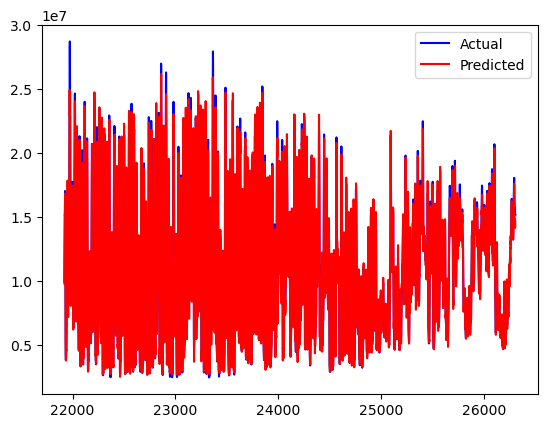

In [120]:
# Create lag features
# df['lag1'] = df['Total_Production'].shift(1)
# df['lag2'] = df['Total_Production'].shift(2)
# df.dropna(inplace=True)

# Example DataFrame `df` with features and target
# df['validto'] should be a datetime column (or already numeric)
X = df[['lag_1', 'lag_2', 'rolling_mean_3', 'month', 'day_of_week']]  # Features
y = df['Total_Production']  # Target variable


# Number of splits for time series
tscv = TimeSeriesSplit(n_splits=5)

# Variables to store the performance metrics
mae_scores = []
rmse_scores = []
mape_xgb_scores = []
smape_xgb_scores = []
aic_xgb_scores = []

model_run_start_time = time.time()

# TimeSeriesSplit loop
for train_index, test_index in tscv.split(X):
    # Split data into train and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate performance metrics for each fold
    mae_xgb = mean_absolute_error(y_test, y_pred)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
    mape_xgb = mean_absolute_percentage_error(y_test, y_pred)
    smape_xgb = symmetric_mape(y_test, y_pred)
    aic_xgb = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)
    
    # Append results to the list
    mae_scores.append(mae_xgb)
    rmse_scores.append(rmse_xgb)
    mape_xgb_scores.append(mape_xgb)
    smape_xgb_scores.append(smape_xgb)
    aic_xgb_scores.append(aic_xgb)

# After the loop, print the average performance metrics across all folds
print("\nAverage MAE:", np.mean(mae_scores))
print("Average RMSE:", np.mean(rmse_scores))
print("\nAverage MAPE:", np.mean(mape_xgb_scores))
print("Average SMAPE:", np.mean(smape_xgb_scores))
print("\nAverage AIC:", np.mean(aic_xgb_scores))

model_run_end_time = time.time()

# Plot Results
import matplotlib.pyplot as plt
plt.plot(y_test.index, y_test, label="Actual", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

# Compute evaluation metrics
mae_xgb = np.mean(mae_scores)
rmse_xgb = np.mean(rmse_scores)


# Calculate execution time in seconds
execution_time = model_run_end_time - model_run_start_time

# Append results to results
results.append(["XGBoost", mae_xgb, rmse_xgb, mape_xgb, smape_xgb, aic_xgb, execution_time])


LTSM (Long Short-Term Memory)

Epoch 1/20


/opt/miniconda3/envs/enexis-mar-visualization/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1315/1315 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.0145
Epoch 2/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 6.7623e-04
Epoch 3/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 5.8486e-04
Epoch 4/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.8063e-04
Epoch 5/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.1910e-04
Epoch 6/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.0112e-04
Epoch 7/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 5.0081e-04
Epoch 8/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4.9692e-04
Epoch 9/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 4.8693e-04
Epoch 10/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 4.7753e-04
Epoch 11/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4.8249e-04
Epoch 12/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - loss: 4.5993e-04
Epoch 13/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 4.4111e-04
Epoch 14/20
1315/1315 ━━━━━━━━━━━━━━━━━━━━ 10s 8m

/var/folders/gy/xs43v__d0mn25qy5kzxrnkrm0000gn/T/ipykernel_25888/3068405381.py:3: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


10322909.482282504 11730675.775453206 inf 199.9999840547442 171231.03622317206


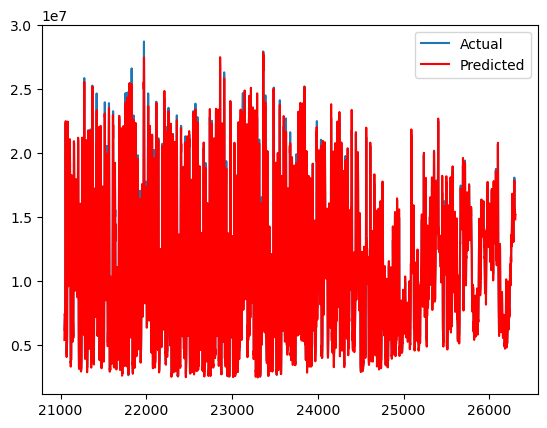

In [121]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = df_pd_orig

# Normalize data
scaler = MinMaxScaler()
df['Total_Production'] = scaler.fit_transform(df[['Total_Production']])

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i: i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Lookback period
data = df['Total_Production'].values
X, y = create_sequences(data, seq_length)

# Split into train/test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build LSTM Model
model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50, activation='relu'),
    Dense(1)
])

# Compile & Train
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=16, verbose=1)

# Predict & Inverse Transform
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)

# Compute evaluation metrics
mae_ltsm = mean_absolute_error(y_test, y_pred)
rmse_ltsm = np.sqrt(mean_squared_error(y_test, y_pred))
mape_ltsm = mean_absolute_percentage_error(y_test, y_pred)
smape_ltsm = symmetric_mape(y_test, y_pred)
aic_ltsm = compute_aic(y_test, y_pred, num_params=X_train.shape[1] + 1)

print(mae_ltsm, rmse_ltsm, mape_ltsm, smape_ltsm, aic_ltsm)

# Append results to results
results.append(["LSTM", mae_ltsm, rmse_ltsm, mape_ltsm, smape_ltsm, aic_ltsm])

# Plot Results
import matplotlib.pyplot as plt
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(df.index[-len(y_test):], y_pred, label="Predicted", color="red")
plt.legend()
plt.show()

Print Model evaluation results

In [122]:
# Convert results to DataFrame
metrics_df = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "MAPE", "sMAPE", "AIC", "Execution Time"])

metrics_df['Comments'] = 'Use of hyperparameter tuning in Random Forest Model'

# Display Table
print(metrics_df)

# Define the filename
model_run_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_results_file_path = f'{MODEL_RUN_RESULTS_DIR}ned-model-results_{model_run_timestamp}.csv'

# Step 10: Check if file exists, then append or create
if os.path.exists(model_results_file_path):
    # Append to existing file
    existing_results = pd.read_csv(model_results_file_path)
    updated_results = pd.concat([existing_results, metrics_df], ignore_index=True)
    updated_results.to_csv(model_results_file_path, index=False)
else:
    # Create new file
    metrics_df.to_csv(model_results_file_path, index=False)

print(f"✅ Model evaluation saved to {model_results_file_path}")

               Model           MAE          RMSE       MAPE       sMAPE  \
0  Linear Regression  4.693591e+06  5.513835e+06  70.124334   47.179160   
1        Naive Model  4.581184e+06  5.879863e+06  49.747321   46.959689   
2      ARIMA (1,1,1)  5.512123e+06  6.393478e+06  92.500570   52.265343   
3    SARIMAX (1,1,3)  5.023410e+06  5.838692e+06  80.642767   49.310896   
4              LASSO  4.693591e+06  5.513835e+06  70.124334   47.179160   
5      Decision Tree  4.578737e+06  5.435265e+06  65.045044   46.401344   
6      Random Forest  4.513491e+06  5.436746e+06  60.768244   45.967689   
7            XGBoost  5.006618e+05  7.373277e+05   5.218027    5.235235   
8               LSTM  1.032291e+07  1.173068e+07        inf  199.999984   

             AIC  Execution Time  \
0  136107.655892        0.027330   
1  136107.655892        0.001093   
2  650761.401768        2.087856   
3  649991.474362        3.314211   
4  136107.655892        0.056246   
5  136107.655892        0.023916 